In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, kstest, norm, t
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.decomposition import PCA
import os
np.random.seed(21)
os.chdir("/Users/kakifang/Documents/duke/fintech540/FinTech545_Spring2025/Projects/Project01")


In [2]:
#problem 1_1
data = pd.read_csv("problem1.csv")  
q1x = data["X"].values
mean_q1x = np.mean(q1x)
var_q1x = np.var(q1x, ddof=1)
skew_q1x = skew(q1x)
kurt_q1x = kurtosis(q1x)

print("Q1_1 Statistics:")
print(f"Mean:      {mean_q1x:.6f}")
print(f"Variance:  {var_q1x:.6f}")
print(f"Skewness:  {skew_q1x:.6f}")
print(f"Kurtosis:  {kurt_q1x:.6f}")
print()




Q1_1 Statistics:
Mean:      0.050198
Variance:  0.010332
Skewness:  0.120445
Kurtosis:  0.222927



In [3]:
#problem 1_3 (AIC)
#get the AIC
mu_q1, sigma_q1 = norm.fit(q1x)
normal_loglike = np.sum(norm.logpdf(q1x, loc=mu_q1, scale=sigma_q1))
df_q1, loc_q1, scale_q1 = t.fit(q1x)
t_loglike = np.sum(t.logpdf(q1x, df_q1, loc=loc_q1, scale=scale_q1))
aic_normal = 2 * 2 - 2 * normal_loglike
aic_t = 2 * 3 - 2 * t_loglike
print("AIC values:")
print(f"Normal AIC: {aic_normal:.6f}")
print(f"t Distribution AIC: {aic_t:.6f}")


AIC values:
Normal AIC: -1731.586729
t Distribution AIC: -1731.418369


In [4]:
#problem 2_1
#read the dataset
data2 = pd.read_csv('problem2.csv')
cov_pairwise = data2.cov()
print("Pairwise Covariance Matrix:\n", cov_pairwise)
    

Pairwise Covariance Matrix:
           x1        x2        x3        x4        x5
x1  1.470484  1.454214  0.877269  1.903226  1.444361
x2  1.454214  1.252078  0.539548  1.621918  1.237877
x3  0.877269  0.539548  1.272425  1.171959  1.091912
x4  1.903226  1.621918  1.171959  1.814469  1.589729
x5  1.444361  1.237877  1.091912  1.589729  1.396186


In [5]:
#problem 2_2
#check if the matrix is PSD
eigenvalues = np.linalg.eigvalsh(cov_pairwise)
is_psd = np.all(eigenvalues >= -1e-8)
print(f"Matrix is PSD: {is_psd}")
print("Eigenvalues:", eigenvalues)

Matrix is PSD: False
Eigenvalues: [-0.31024286 -0.13323183  0.02797828  0.83443367  6.78670573]


In [6]:
# problem 2_3
#H method
def PS(X):
    eigvals, eigvecs = np.linalg.eigh(X)
    eigvals = np.maximum(eigvals, 0)
    return eigvecs @ np.diag(eigvals) @ eigvecs.T

def PU(X):
    Y = X.copy()
    n = Y.shape[0]
    for i in range(n):
        Y[i, i] = 1
    return Y

def Norm(A):
    row_sums = np.sum(np.abs(A), axis=1)
    return np.max(row_sums)

def Higham(A, max_iter=100, tol=1e-8):
    Yold = A.copy()
    Xold = A.copy()
    dS = np.zeros_like(A)
    for _ in range(max_iter):
        R = Yold - dS
        X = PS(R)
        dS = X - R
        Y = PU(X)
        diff_Y = Norm(Y - Yold) / Norm(Y)
        diff_X = Norm(X - Xold) / Norm(X)
        diff_YX = Norm(Y - X) / Norm(Y)
        max_diff = max(diff_Y, diff_X, diff_YX)
        if max_diff <= tol:
            break
        Xold = X.copy()
        Yold = Y.copy()
    return X

#corr_matrix prepartion
var_2_3 = np.diag(cov_pairwise)
std_2_3 = np.sqrt(var_2_3)
D_2_3 = np.diag(std_2_3)
D_inv_2_3 = np.diag(1.0 / std_2_3)
corr_matrix_2_3 = D_inv_2_3 @ cov_pairwise @ D_inv_2_3

#apply to the function
corr_pshm_2_3 = Higham(corr_matrix_2_3)

#convert it back
cov_pshm_2_3 = D_2_3 @ corr_pshm_2_3 @ D_2_3
cov_pshm_df_2_3 = pd.DataFrame(cov_pshm_2_3, index=cov_pairwise.columns, columns=cov_pairwise.columns)
print("\nHigham's Nearest PSD Matrix:")
print(cov_pshm_df_2_3)

#check if psd
eigenvalueshm_2_3 = np.linalg.eigvalsh(cov_pshm_df_2_3)
is_pshm_2_3 = np.all(eigenvalueshm_2_3 >= -1e-8)
print(f"\nMatrix is PSD: {is_pshm_2_3}")




Higham's Nearest PSD Matrix:
          x1        x2        x3        x4        x5
x1  1.470484  1.332361  0.884378  1.627602  1.399556
x2  1.332361  1.252078  0.619028  1.450604  1.214450
x3  0.884378  0.619028  1.272425  1.076847  1.059658
x4  1.627602  1.450604  1.076847  1.814469  1.577928
x5  1.399556  1.214450  1.059658  1.577928  1.396186

Matrix is PSD: True


In [7]:
#RJ method
def RJ(A, eps=0):
    n = A.shape[0]
    w, v = np.linalg.eig(A)
    w = np.matrix(np.maximum(w, eps))
    v = np.matrix(v)
    T = 1 / (np.multiply(v, v) * w.T)
    T = np.matrix(np.sqrt(np.diag(np.array(T).reshape(n))))
    B = T * v * np.diag(np.array(np.sqrt(w)).reshape(n))
    
    return B * B.T

#apply the function
corr_psrj_2_3 = RJ(corr_matrix_2_3)
cov_psrj_2_3 = D_2_3 @ corr_psrj_2_3 @ D_2_3

#convert back
cov_psrj_df_2_3 = pd.DataFrame(cov_psrj_2_3, index=cov_pairwise.columns, columns=cov_pairwise.columns)
print("\nRebonato and Jackel's Nearest PSD Matrix:")
print(cov_psrj_df_2_3)

#check if psd
eigenvaluesrj_corr = np.linalg.eigvalsh(cov_psrj_df_2_3)
is_psdrj_corr = np.all(eigenvaluesrj_corr >= -1e-8)
print(f"\nMatrix is PSD: {is_psdrj_corr}")


Rebonato and Jackel's Nearest PSD Matrix:
          x1        x2        x3        x4        x5
x1  1.470484  1.327009  0.842583  1.624464  1.364833
x2  1.327009  1.252078  0.555421  1.433109  1.165906
x3  0.842583  0.555421  1.272425  1.052789  1.060424
x4  1.624464  1.433109  1.052789  1.814469  1.544993
x5  1.364833  1.165906  1.060424  1.544993  1.396186

Matrix is PSD: True


In [8]:
#problem 2_4
#remove missing value row
df_overlap = data2.dropna()
cov_overlap = df_overlap.cov()
print("\nOverlap Covariance Matrix:\n", cov_overlap)
#check PSD
eigenvalues = np.linalg.eigvalsh(cov_overlap)
is_psd = np.all(eigenvalues >= -1e-8)
print(f"\nMatrix is PSD: {is_psd}")


Overlap Covariance Matrix:
           x1        x2        x3        x4        x5
x1  0.418604  0.394054  0.424457  0.416382  0.434287
x2  0.394054  0.396786  0.409343  0.398401  0.422631
x3  0.424457  0.409343  0.441360  0.428441  0.448957
x4  0.416382  0.398401  0.428441  0.437274  0.440167
x5  0.434287  0.422631  0.448957  0.440167  0.466272

Matrix is PSD: True


In [12]:
#problem 3_1
data3 = pd.read_csv('problem3.csv')
Xq3 = data3[["x1", "x2"]].values
muq3 = np.mean(Xq3, axis=0)
Sigmaq3 = np.cov(Xq3.T, bias=False)
print("Estimated mean vector:", muq3)
print("Estimated covariance matrix:\n", Sigmaq3)


Estimated mean vector: [0.04600157 0.09991502]
Estimated covariance matrix:
 [[0.0101622  0.00492354]
 [0.00492354 0.02028441]]


In [13]:
#problem 3_2
#direct formula method
mu1 = muq3[0]
mu2 = muq3[1]

sigma11 = Sigmaq3[0,0]
sigma12 = Sigmaq3[0,1]
sigma22 = Sigmaq3[1,1]

x1value = 0.6
cond_mean = mu2 + (sigma12 / sigma11) * (x1value - mu1)
cond_var= sigma22 - (sigma12 * sigma12 / sigma11)

print("Method 1 (conditional formula) given X1 = 0.6:")
print(f"cond_mean: {cond_mean}")
print(f"cond_var: {cond_var}")

#OLS method
betaq3 = sigma12 / sigma11
alphaq3 = mu2 - betaq3 * mu1
print("\nMethod 2 (OLS) given X1 = 0.6:")
print(f"OLS slope = {betaq3}")
print(f"OLS intercept = {alphaq3}")
cond_mean_ols = alphaq3 + betaq3*x1value
cond_var_ols = sigma22 - (sigma12**2 / sigma11)
print(f"OLS_mean: {cond_mean_ols}")
print(f"OLS_var: {cond_var_ols}")


Method 1 (conditional formula) given X1 = 0.6:
cond_mean: 0.3683249958609774
cond_var: 0.01789896964508753

Method 2 (OLS) given X1 = 0.6:
OLS slope = 0.4844959102797748
OLS intercept = 0.07762744969311253
OLS_mean: 0.3683249958609774
OLS_var: 0.01789896964508753


In [16]:
#Part3_3 
L = np.linalg.cholesky(Sigmaq3)
np.random.seed(21)
Z = np.random.normal(size=(10000, 2))
#generate sample
samples = np.dot(Z, L.T) + muq3
#simulate
Z1 = (x1value - mu1) / L[0, 0]
X2_simulation = mu2 + L[1, 0] * Z1 + L[1, 1] * Z[:, 1]

print(f"X2_simulation: {X2_simulation}")

#compute
simulated_mean = np.mean(X2_simulation)
simulated_variance = np.var(X2_simulation)
print(f"Simulated mean of X2 | X1=0.6: {simulated_mean}")
print(f"Simulated variance of X2 | X1=0.6: {simulated_variance}")


X2_simulation: [0.35344841 0.20018958 0.13940819 ... 0.28335429 0.44463506 0.48294723]
Simulated mean of X2 | X1=0.6: 0.37135179656862566
Simulated variance of X2 | X1=0.6: 0.017759021836734952


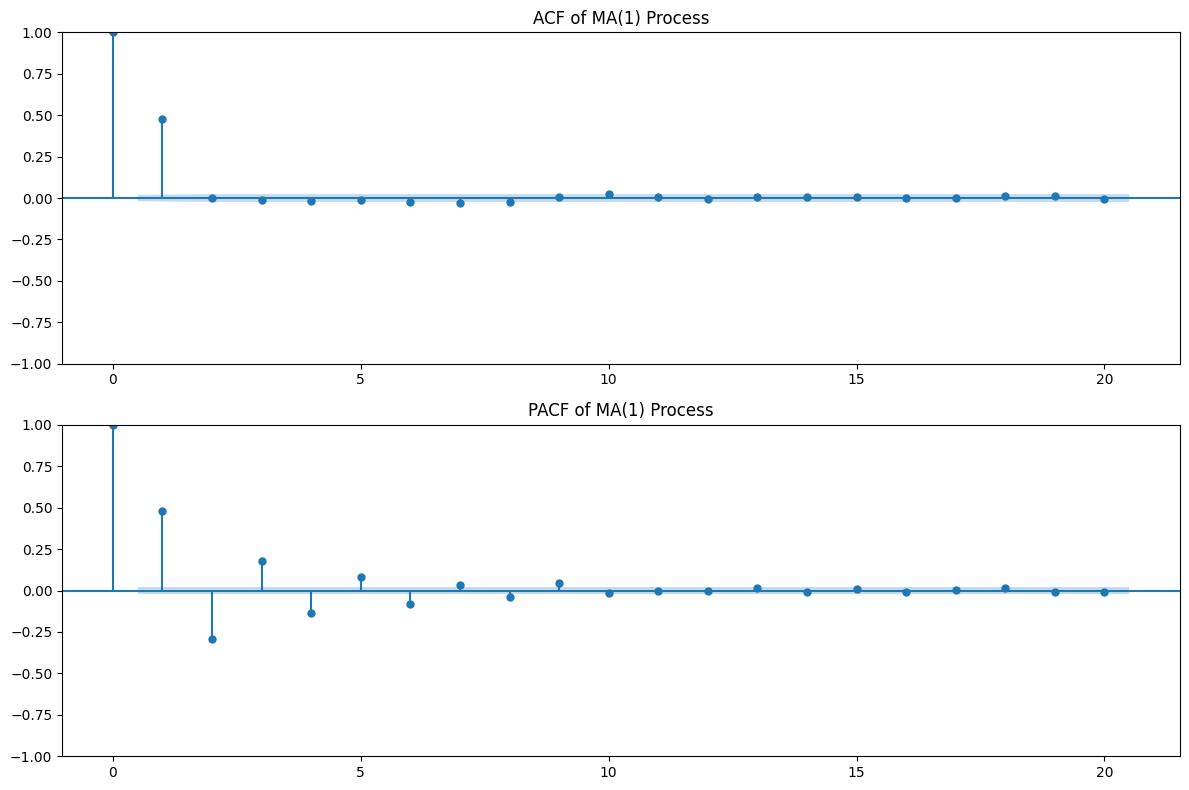

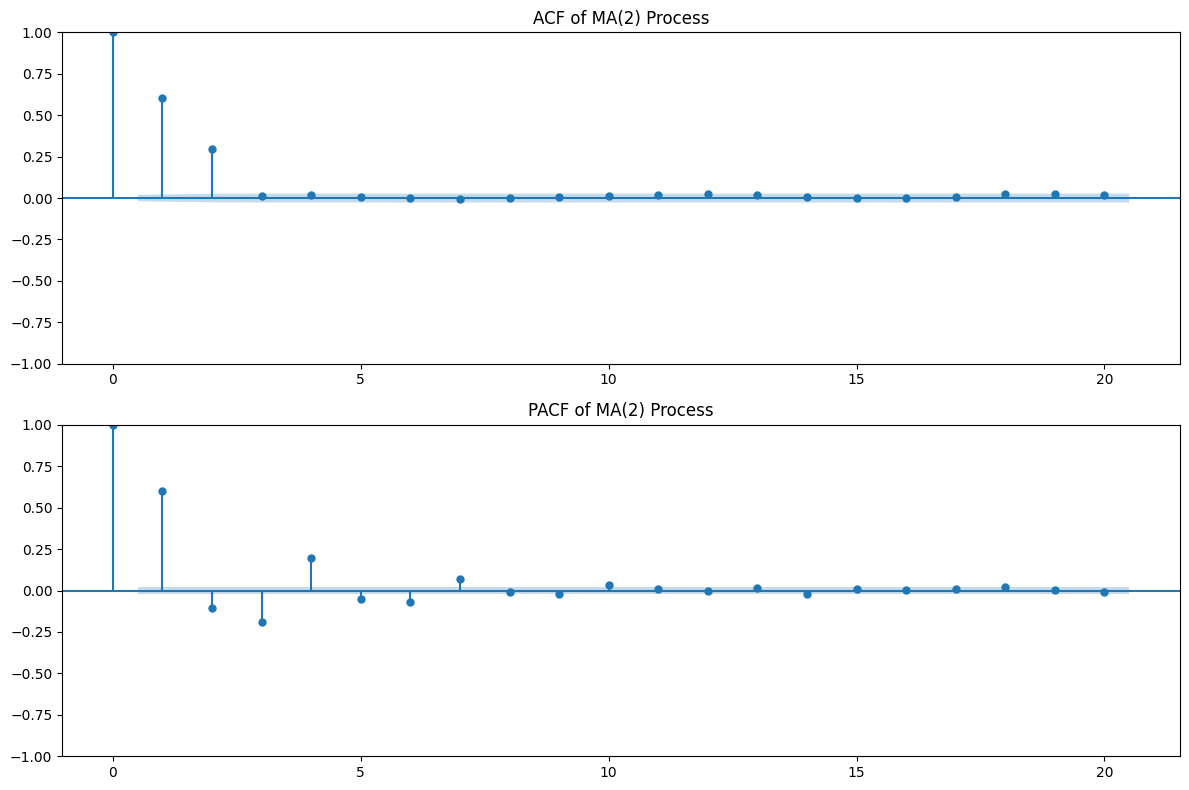

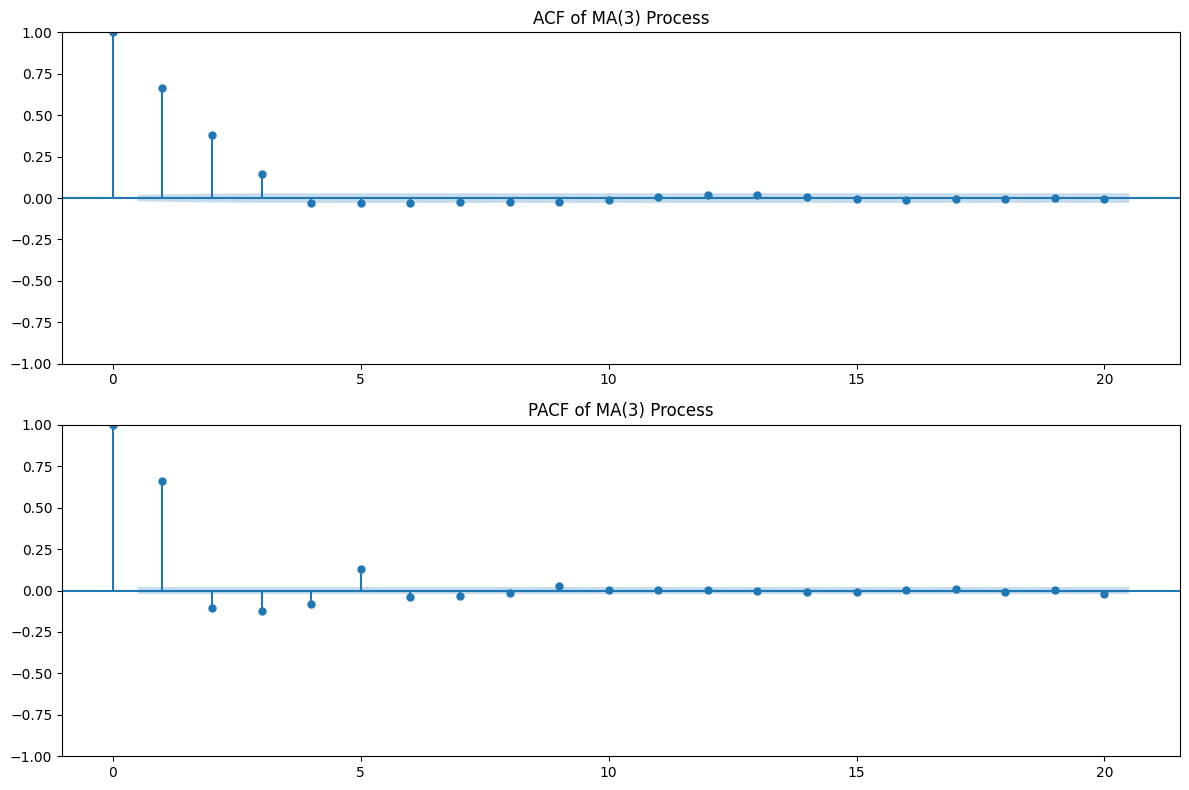

In [17]:
#problem 4
#MA1
ma1 = ArmaProcess(ar=[1], ma=[1, 0.7])
y_ma1 = ma1.generate_sample(nsample=10000)
#MA2
ma2 = ArmaProcess(ar=[1], ma=[1, 0.7, 0.5])
y_ma2 = ma2.generate_sample(nsample=10000)
#MA3
ma3 = ArmaProcess(ar=[1], ma=[1, 0.7, 0.5, 0.3])
y_ma3 = ma3.generate_sample(nsample=10000)
#plot
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plot_acf(y_ma1, lags=20, ax=plt.gca())
plt.title('ACF of MA(1) Process')
plt.subplot(2, 1, 2)
plot_pacf(y_ma1, lags=20, ax=plt.gca())
plt.title('PACF of MA(1) Process')
plt.tight_layout()
plt.show()
#plot
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plot_acf(y_ma2, lags=20, ax=plt.gca())
plt.title('ACF of MA(2) Process')
plt.subplot(2, 1, 2)
plot_pacf(y_ma2, lags=20, ax=plt.gca())
plt.title('PACF of MA(2) Process')
plt.tight_layout()
plt.show()
#plot
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plot_acf(y_ma3, lags=20, ax=plt.gca())
plt.title('ACF of MA(3) Process')
plt.subplot(2, 1, 2)
plot_pacf(y_ma3, lags=20, ax=plt.gca())
plt.title('PACF of MA(3) Process')
plt.tight_layout()
plt.show()


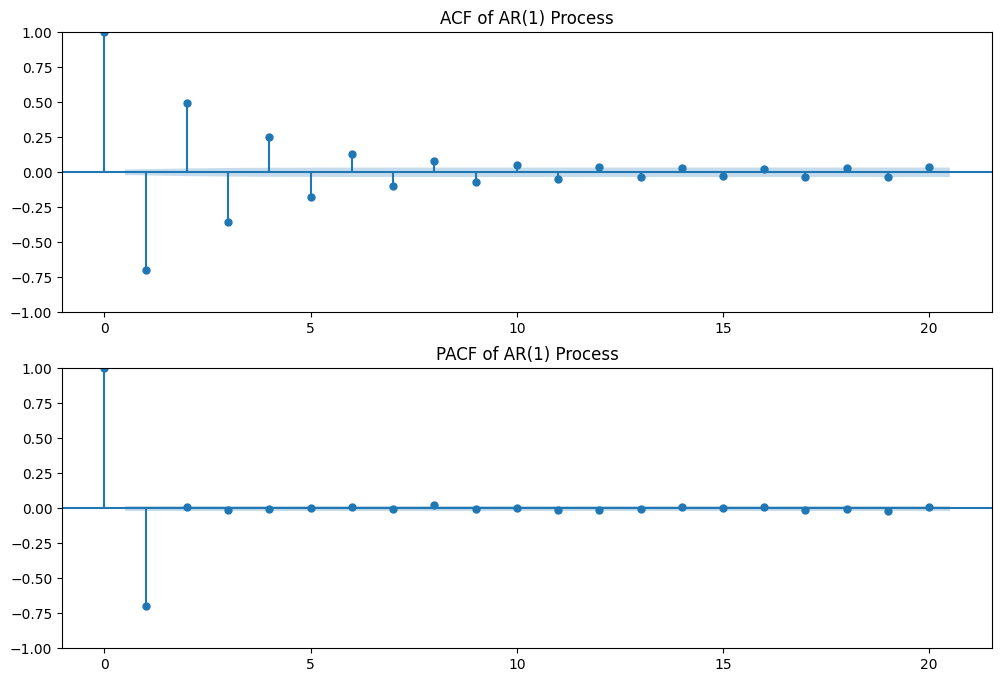

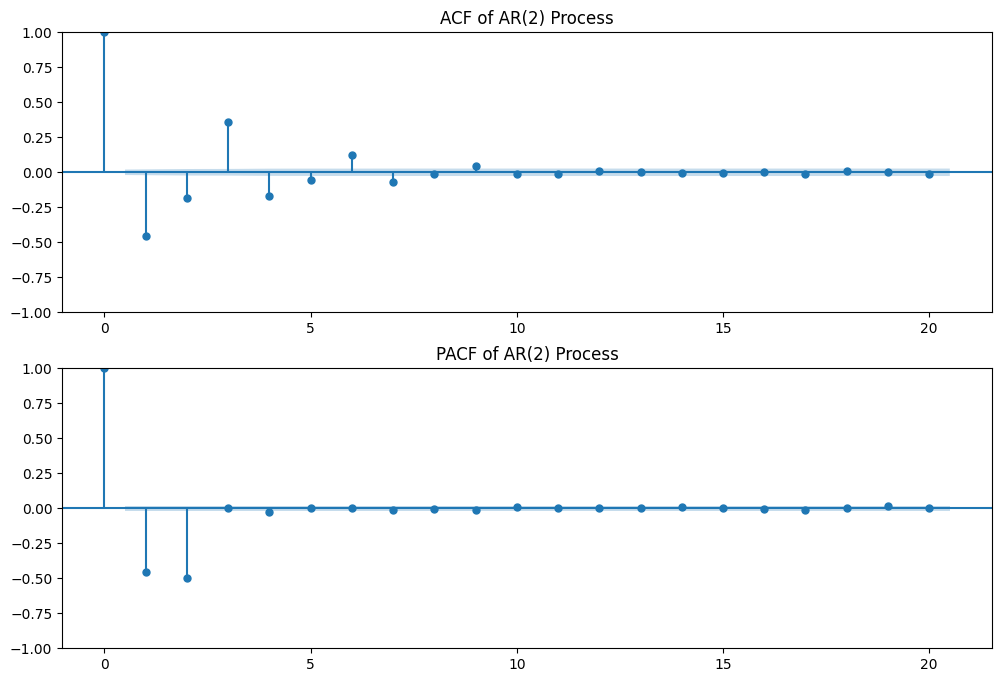

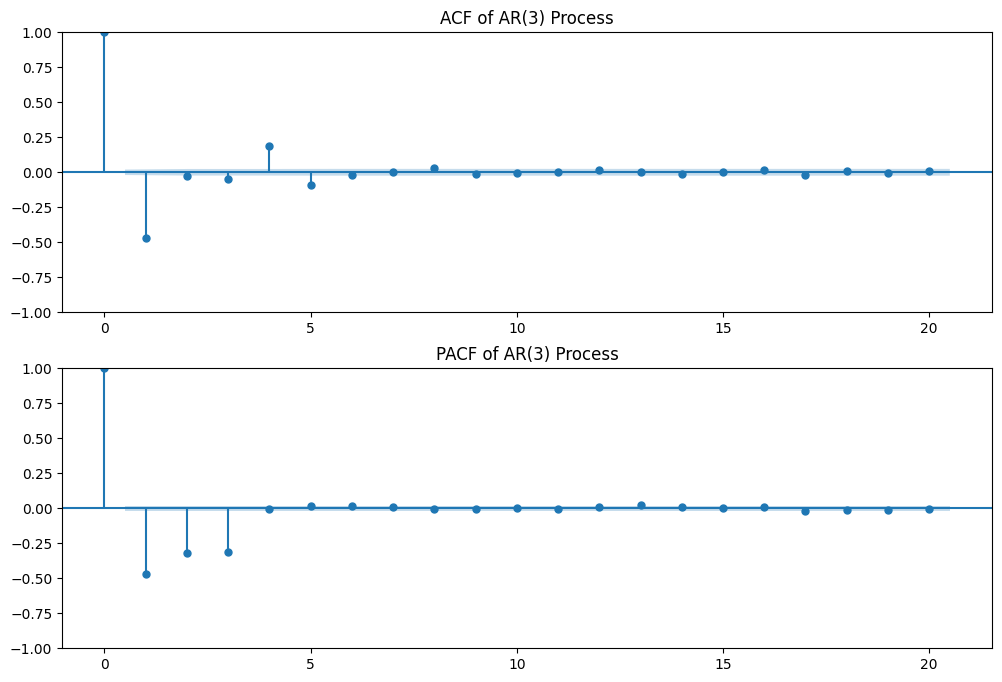

In [18]:
#problem 4_2
#ar1
ar1 = ArmaProcess(ar=[1, 0.7], ma  = [1])
y_ar1 = ar1.generate_sample(nsample=10000)
#ar2
ar2 = ArmaProcess(ar=[1, 0.7, 0.5], ma  = [1])
y_ar2 = ar2.generate_sample(nsample=10000)
#ar3
ar3 = ArmaProcess(ar=[1, 0.7, 0.5, 0.3], ma  = [1])
y_ar3 = ar3.generate_sample(nsample=10000)
#plot
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plot_acf(y_ar1, lags=20, ax=plt.gca())
plt.title('ACF of AR(1) Process')
plt.subplot(2, 1, 2)
plot_pacf(y_ar1, lags=20, ax=plt.gca())
plt.title('PACF of AR(1) Process')
plt.show()
#plot ar2
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plot_acf(y_ar2, lags=20, ax=plt.gca())
plt.title('ACF of AR(2) Process')
plt.subplot(2, 1, 2)
plot_pacf(y_ar2, lags=20, ax=plt.gca())
plt.title('PACF of AR(2) Process')
plt.show()
#plot ar3
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plot_acf(y_ar3, lags=20, ax=plt.gca())
plt.title('ACF of AR(3) Process')

plt.subplot(2, 1, 2)
plot_pacf(y_ar3, lags=20, ax=plt.gca())
plt.title('PACF of AR(3) Process')
plt.show()

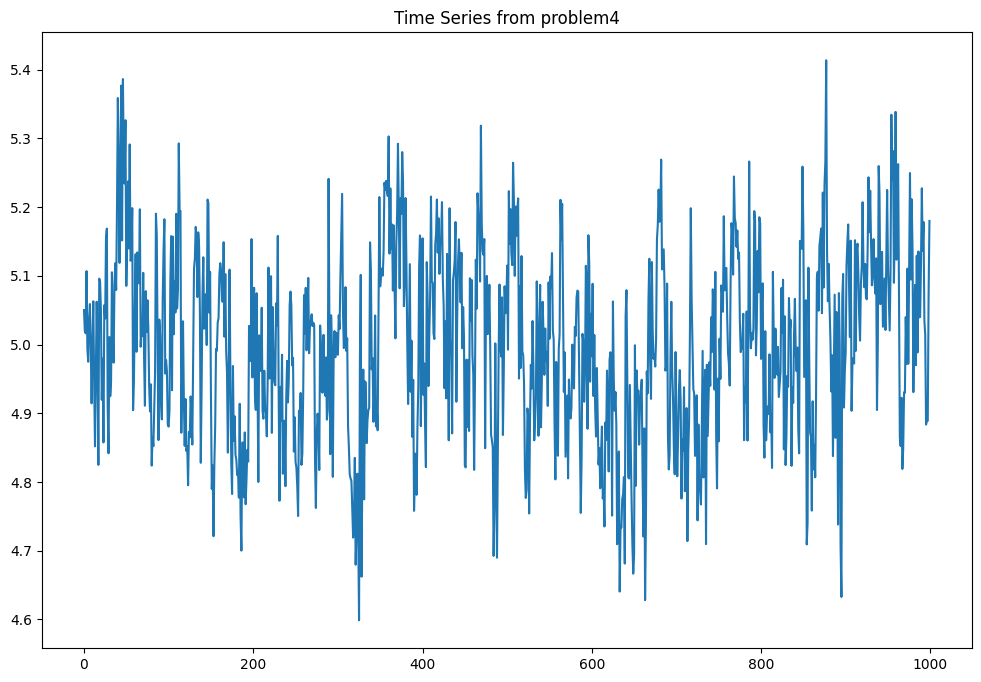

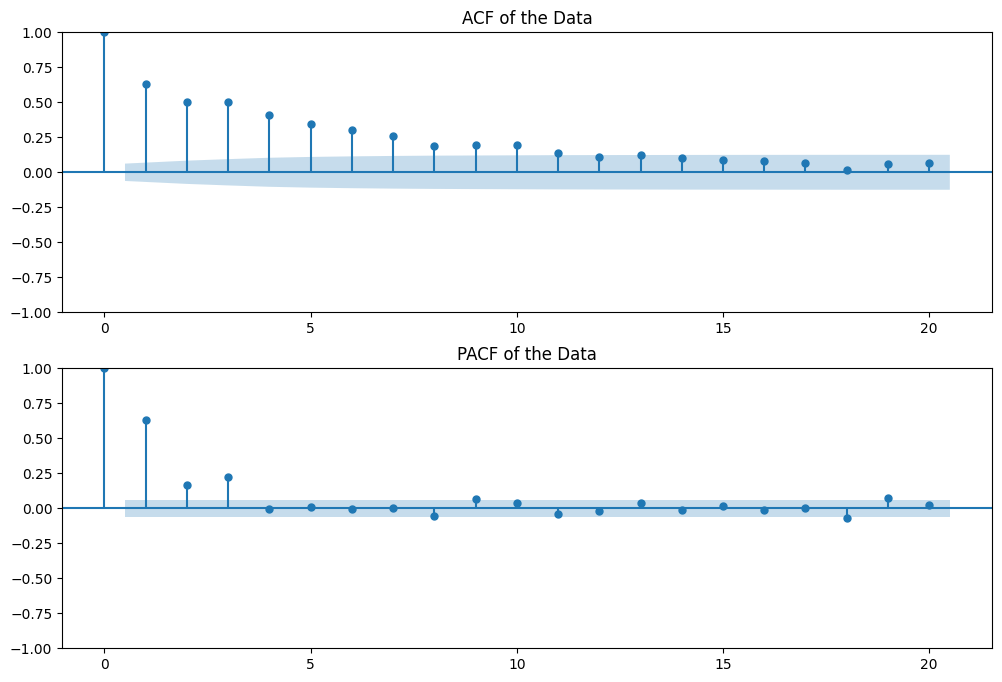

In [19]:
#problem 4_3
#load data
df = pd.read_csv('problem4.csv')
y = df['y'].values

#plot
plt.figure(figsize=(12,8))
plt.plot(y, label='Problem4 Data')
plt.title('Time Series from problem4')
plt.show()

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plot_acf(y, lags=20, ax=plt.gca())
plt.title('ACF of the Data')

plt.subplot(2, 1, 2)
plot_pacf(y, lags=20, ax=plt.gca())
plt.title('PACF of the Data')

plt.show()



In [20]:
#problem 4_4
# Define model orders to test
mods = {
    'AR(1)': (1, 0, 0),
    'AR(2)': (2, 0, 0),
    'AR(3)': (3, 0, 0),
    'AR(4)': (4, 0, 0),
    'MA(1)': (0, 0, 1),
    'MA(2)': (0, 0, 2),
    'MA(3)': (0, 0, 3),
    'MA(4)': (0, 0, 4),
}

# List to store results
result = []

# Loop over each model and try to fit it
for nm, ord in mods.items():
    mod = ARIMA(y, order=ord)
    fit = mod.fit()
    result.append({
        'Model': nm,
        'Order': ord,
        'AICc': round(fit.aicc, 2)
    }) 

#build dataframe
r_df = pd.DataFrame(result)[['Model', 'Order', 'AICc']]
#sort it
r_df['AICc'] = pd.to_numeric(r_df['AICc'])
r_df = r_df.sort_values(by='AICc', na_position='last')
r_df = r_df.reset_index(drop=True)
print("Model Comparison Results:")
print(r_df)


Model Comparison Results:
   Model      Order     AICc
0  AR(3)  (3, 0, 0) -1746.22
1  AR(4)  (4, 0, 0) -1744.22
2  AR(2)  (2, 0, 0) -1696.05
3  MA(4)  (0, 0, 4) -1677.50
4  AR(1)  (1, 0, 0) -1669.07
5  MA(3)  (0, 0, 3) -1645.07
6  MA(2)  (0, 0, 2) -1559.21
7  MA(1)  (0, 0, 1) -1508.90


In [22]:
#problem 5_1
df5 = pd.read_csv("DailyReturn.csv", index_col=0)
df5 = df5.apply(pd.to_numeric, errors='coerce').dropna()

def ewma_covariance_matrix(returns, lambda_value):
    # Determine the number of days and stocks
    days = returns.shape[0]
    stocks = returns.shape[1]
    weights_list = []
    for i in range(days):
        w = (1 - lambda_value) * (lambda_value ** i)
        weights_list.append(w)
    weights_list.reverse()
    weights = np.array(weights_list)
    total_weight = weights.sum()
    weights = weights / total_weight
    #Compute Weighted Means
    returns_array = returns.values
    avg_values = np.average(returns_array, axis=0, weights=weights)  
    #reshape
    weighted_means = avg_values.reshape(-1, 1)
    #compute ewma
    ewma_cov = np.zeros((stocks, stocks))
    #loop through days
    for day_val, wt in zip(returns_array, weights):
        diff = day_val.reshape(-1, 1) - weighted_means
        ewma_cov += wt * diff.dot(diff.T)

    return ewma_cov



cov_matrix_ewma = ewma_covariance_matrix(df5, 0.97)
cov_matrix_ewma_df = pd.DataFrame(cov_matrix_ewma, index=df5.columns, columns=df5.columns)

print("Exponentially Weighted Covariance Matrix (λ = 0.97):")
print(cov_matrix_ewma_df)


Exponentially Weighted Covariance Matrix (λ = 0.97):
           SPY      AAPL      NVDA      MSFT      AMZN      META     GOOGL  \
SPY   0.000072  0.000054  0.000124  0.000080  0.000112  0.000081  0.000088   
AAPL  0.000054  0.000139  0.000041  0.000084  0.000081  0.000056  0.000071   
NVDA  0.000124  0.000041  0.000663  0.000133  0.000196  0.000186  0.000145   
MSFT  0.000080  0.000084  0.000133  0.000161  0.000174  0.000126  0.000122   
AMZN  0.000112  0.000081  0.000196  0.000174  0.000323  0.000188  0.000201   
...        ...       ...       ...       ...       ...       ...       ...   
KKR   0.000135  0.000041  0.000220  0.000105  0.000188  0.000119  0.000161   
MU    0.000148  0.000055  0.000304  0.000151  0.000173  0.000165  0.000167   
PLD   0.000059  0.000060  0.000014  0.000061  0.000057  0.000014  0.000025   
LRCX  0.000127  0.000084  0.000322  0.000152  0.000185  0.000229  0.000158   
EQIX  0.000053  0.000038  0.000050  0.000054  0.000071  0.000074  0.000051   

          

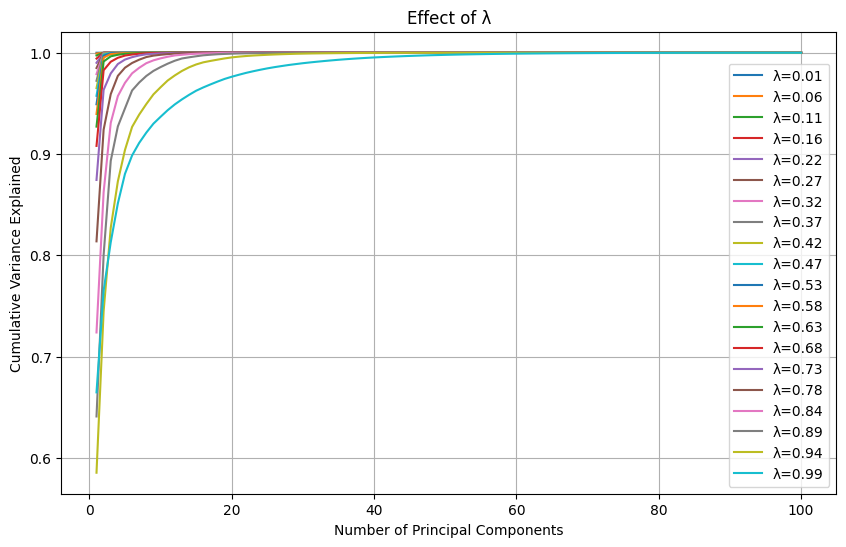

In [23]:
#problem 5_2
# Define a range of lambda values
lambda_values = np.linspace(0.01, 0.99, 20)

#store variances
cumulative_variances = {}

#perform all PCA
for lambda_val in lambda_values:
    ewma_cov_n = ewma_covariance_matrix(df5, lambda_val)
    pca = PCA()
    pca.fit(ewma_cov_n)
    cumulative_var = np.cumsum(pca.explained_variance_ratio_)
    cumulative_variances[lambda_val] = cumulative_var

#plot
plt.figure(figsize=(10, 6))

for lambda_val, cumulative_var in cumulative_variances.items():
    plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, label=f'λ={lambda_val:.2f}')

plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.title("Effect of λ")
plt.legend()
plt.grid(True)
plt.show()


In [24]:
#problem 6_1
import numpy as np
import pandas as pd

np.random.seed(21)

df_cov = pd.read_csv("problem6.csv", header=0)
cov_matrix6 = df_cov.to_numpy()
eigenvalues = np.linalg.eigvalsh(cov_matrix6)
is_pd = np.all(eigenvalues > 1e-8)
print(f"Covariance matrix is Positive Definite (PD): {is_pd}")

Covariance matrix is Positive Definite (PD): False


In [25]:
#problem 6_1
def PS(X):
    eigvals, eigvecs = np.linalg.eigh(X)
    eigvals = np.maximum(eigvals, 0)
    return eigvecs @ np.diag(eigvals) @ eigvecs.T

def PU(X):
    Y = X.copy()
    n = Y.shape[0]
    for i in range(n):
        Y[i, i] = 1
    return Y

def Norm(A):
    row_sums = np.sum(np.abs(A), axis=1)
    return np.max(row_sums)

def Higham(A, max_iter=100, tol=1e-8):
    Yold = A.copy()
    Xold = A.copy()
    dS = np.zeros_like(A)
    for _ in range(max_iter):
        R = Yold - dS
        X = PS(R)
        dS = X - R
        Y = PU(X)
        diff_Y = Norm(Y - Yold) / Norm(Y)
        diff_X = Norm(X - Xold) / Norm(X)
        diff_YX = Norm(Y - X) / Norm(Y)
        max_diff = max(diff_Y, diff_X, diff_YX)
        if max_diff <= tol:
            break
        Xold = X.copy()
        Yold = Y.copy()
    return X


#corr_matrix prepartion
var_6 = np.diag(cov_matrix6)
std_6 = np.sqrt(var_6)
D_6= np.diag(std_6)
D_inv_6 = np.diag(1.0 / std_6)
corr_matrix_6 = D_inv_6 @ cov_matrix6 @ D_inv_6


#apply to the function
corr_pshm_6= Higham(corr_matrix_6)

#convert it back
cov_pshm_6 = D_6 @ corr_pshm_6 @ D_6
cov_pshm_df_6 = pd.DataFrame(cov_pshm_6, index=df_cov.columns.tolist(), columns=df_cov.columns.tolist())
print("\nHigham's Nearest PSD Matrix:")
print(cov_pshm_df_6)

values, vectors = np.linalg.eigh(cov_pshm_df_6.values)
values = np.maximum(values, 1e-10)
cov_lifted = vectors @ np.diag(values) @ vectors.T
print("\nHigham's Nearest PSD Matrix:")
print(cov_lifted)


Higham's Nearest PSD Matrix:
            x1        x2        x3        x4        x5        x6        x7  \
x1    0.005315  0.000215 -0.000777  0.000418 -0.000687  0.000166  0.000935   
x2    0.000215  0.001781  0.000094 -0.000109 -0.000438  0.000523 -0.000803   
x3   -0.000777  0.000094  0.004925  0.000320 -0.000592  0.000418 -0.000195   
x4    0.000418 -0.000109  0.000320  0.002545 -0.000323 -0.000106  0.000165   
x5   -0.000687 -0.000438 -0.000592 -0.000323  0.009133 -0.001379 -0.002163   
...        ...       ...       ...       ...       ...       ...       ...   
x496 -0.000149 -0.000190 -0.000761  0.000310  0.001203 -0.000321 -0.000407   
x497  0.000021  0.000009 -0.000269  0.000172  0.000028 -0.000077 -0.000186   
x498  0.000237  0.000370 -0.000335  0.000148  0.000201 -0.000211  0.000027   
x499  0.001169  0.000707  0.000360  0.000761 -0.001461 -0.000144 -0.000473   
x500 -0.000095  0.000139 -0.000124  0.000240  0.000078 -0.000151 -0.000247   

            x8        x9       x1

In [26]:
#cholesky
import time
nearest_cov_psd_df = cov_lifted

start_chol = time.time()
L = np.linalg.cholesky(nearest_cov_psd_df)
np.random.seed(21)
#generate draws
Z_chol = np.random.normal(size=(10000, 500))
#simulating
sim_chol = Z_chol @ L.T 
print(sim_chol)
end_chol = time.time()
time_chol = end_chol - start_chol
print(f"Time (Cholesky): {time_chol:.4f} seconds")


[[-0.00378849 -0.00483474  0.07241535 ... -0.04268456  0.10774084
  -0.0300158 ]
 [-0.01616741 -0.0241745  -0.07708318 ...  0.05651221 -0.06902595
   0.01011187]
 [ 0.11254952  0.00856622  0.03216331 ...  0.09651671  0.06466688
  -0.02327996]
 ...
 [-0.05220491 -0.10006318 -0.00510949 ... -0.06580697 -0.16780865
  -0.02867459]
 [-0.03300452 -0.01590807 -0.02061451 ...  0.01419416  0.05843202
   0.00698822]
 [ 0.04738729 -0.03980041 -0.10694649 ...  0.01888001  0.00712492
   0.01207993]]
Time (Cholesky): 0.2736 seconds


In [27]:
#problem 6_2 PCA method
start_pca = time.time()

eigvals, eigvecs = np.linalg.eigh(nearest_cov_psd_df)
#sort it
value_desc = np.argsort(eigvals)[::-1]
eigvals_sorted = eigvals[value_desc]
eigvecs_sorted = eigvecs[:, value_desc]

#compute variance ratio
cumulative_vals = np.cumsum(eigvals_sorted)
total_val = cumulative_vals[-1]

#find k
target = 0.75 * total_val
k = np.searchsorted(cumulative_vals, target) + 1

print(f"k={k}")

# keep the value top k
eigvals_k = eigvals_sorted[:k]
eigvecs_k = eigvecs_sorted[:, :k]
sqrt_lambda_k = np.sqrt(eigvals_k)

# generate draw by k
np.random.seed(21)
Z_k = np.random.normal(size=(10000, k))

# transform it
sim_pca = Z_k @ np.diag(sqrt_lambda_k) @ eigvecs_k.T

print(sim_pca)
end_pca = time.time()
time_pca = end_pca - start_pca
print(f"Time (PCA): {time_pca:.4f} seconds")


k=45
[[ 0.08788078  0.01648881 -0.05526702 ... -0.06730822  0.1023446
   0.02012903]
 [ 0.10932989  0.01155781 -0.08378176 ...  0.01505862  0.00303375
   0.02898716]
 [-0.13493637 -0.0344283   0.16271951 ... -0.04937761  0.00726931
  -0.03856626]
 ...
 [ 0.08783624  0.01780638 -0.12283303 ...  0.06970027  0.05053552
   0.02286392]
 [ 0.00588567 -0.04270026 -0.02572529 ... -0.01948072 -0.11276811
   0.0307553 ]
 [-0.0730733  -0.03279773  0.07854064 ...  0.00827236 -0.00982329
  -0.0095053 ]]
Time (PCA): 0.0978 seconds


In [28]:
#problem 6_3
cov_chol_hat = np.cov(sim_chol, rowvar=False)
cov_pca_hat  = np.cov(sim_pca,  rowvar=False)

#compute Frobenius norms
fro_chol = np.linalg.norm(cov_chol_hat - cov_matrix6, 'fro')
fro_pca  = np.linalg.norm(cov_pca_hat  - cov_matrix6, 'fro')

print("Frobenius difference (Cholesky vs original):", fro_chol)
print("Frobenius difference (PCA vs original):",      fro_pca)


Frobenius difference (Cholesky vs original): 0.020943948321592378
Frobenius difference (PCA vs original): 0.08315006650779189


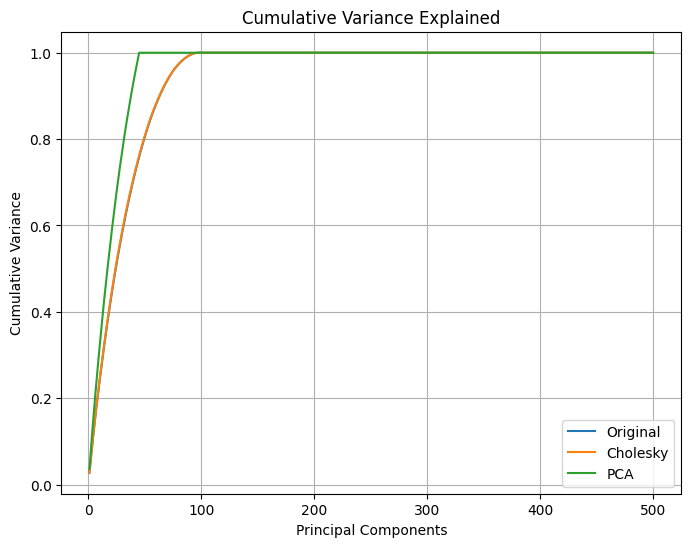

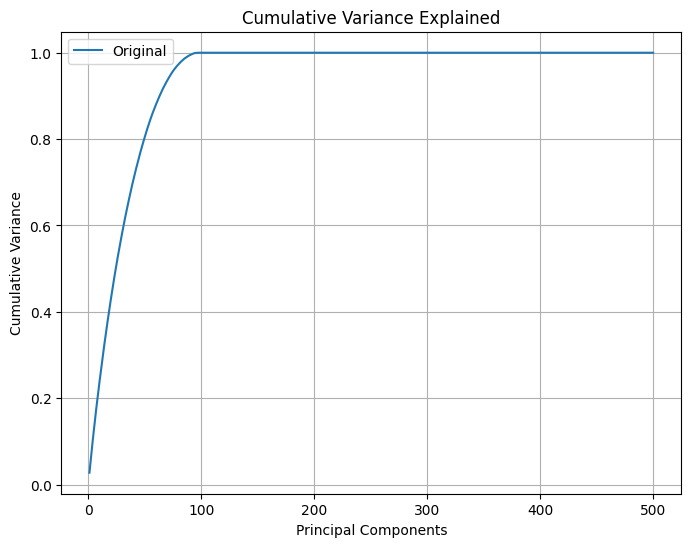

In [29]:
#problem 6_4
def cumulative_variance_explained(cov_mat):
    """Return sorted eigenvalues (descending) and their cumulative sum ratio."""
    evals, _ = np.linalg.eigh(cov_mat)
    sorted_evals = np.sort(evals)[::-1]  # descending order
    cumsum = np.cumsum(sorted_evals)
    total = np.sum(sorted_evals)
    return cumsum / total

#get data
cvar_orig = cumulative_variance_explained(nearest_cov_psd_df)
cvar_chol = cumulative_variance_explained(cov_chol_hat)
cvar_pca  = cumulative_variance_explained(cov_pca_hat)

x_vals = np.arange(1, 501)

#plot
plt.figure(figsize=(8, 6))
plt.plot(x_vals, cvar_orig, label="Original")
plt.plot(x_vals, cvar_chol, label="Cholesky")
plt.plot(x_vals, cvar_pca,  label="PCA")

plt.xlabel("Principal Components")
plt.ylabel("Cumulative Variance")
plt.title("Cumulative Variance Explained")
plt.legend(loc="best")

plt.grid(True)
plt.show()

#the plot overlapped so plot the second one

plt.figure(figsize=(8, 6))
plt.plot(x_vals, cvar_orig, label="Original")
plt.xlabel("Principal Components")
plt.ylabel("Cumulative Variance")
plt.title("Cumulative Variance Explained")
plt.legend(loc="best")

plt.grid(True)
plt.show()

In [30]:
#problem 6_5
print(f"Time taken (Cholesky): {time_chol:.4f} seconds")
print(f"Time taken (PCA): {time_pca:.4f} seconds")


Time taken (Cholesky): 0.2736 seconds
Time taken (PCA): 0.0978 seconds
